In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model

In [2]:
dhw_merge = pd.read_csv('dhw_merge.csv')
elec_merge  = pd.read_csv('elec_merge.csv')
n_elec_merge = pd.read_csv('n_elec_merge.csv')

dhw_merge = dhw_merge.drop(['YEAR'], axis=1)
elec_merge = elec_merge.drop(['YEAR'], axis=1)
n_elec_merge = n_elec_merge.drop(['YEAR'], axis=1)

In [3]:
# dhw_merge = dhw_merge.drop(['YEAR','date'], axis=1)
# elec_merge = elec_merge.drop(['YEAR','date'], axis=1)
# n_elec_merge = n_elec_merge.drop(['YEAR','date'], axis=1)

##  For Scaling

In [4]:
dhw_X = dhw_merge.drop(['DHW'], axis=1)
dhw_Y = dhw_merge[['DHW']]

scaler_dhw = MinMaxScaler()
scaler_dhw.fit(dhw_X)
scaled_dhw_X = scaler_dhw.transform(dhw_X)

new_dhw_X = pd.DataFrame(scaled_dhw_X, index=dhw_X.index, columns=dhw_X.columns)
new_dhw = pd.concat([new_dhw_X, dhw_Y], axis=1)

In [5]:
elec_X = elec_merge.drop(['ELEC'], axis=1)
elec_Y = elec_merge[['ELEC']]

scaler_elec = MinMaxScaler()
scaler_elec.fit(elec_X)
scaled_elec_X = scaler_elec.transform(elec_X)

new_elec_X = pd.DataFrame(scaled_elec_X, index=elec_X.index, columns=elec_X.columns)
new_elec = pd.concat([new_elec_X, elec_Y], axis=1)

In [6]:
n_elec_X = n_elec_merge.drop(['n_elec'], axis=1)
n_elec_Y = n_elec_merge[['n_elec']]

scaler_n_elec = MinMaxScaler()
scaler_n_elec.fit(n_elec_X)
scaled_n_elec_X = scaler_n_elec.transform(n_elec_X)

new_n_elec_X = pd.DataFrame(scaled_n_elec_X, index=n_elec_X.index, columns=n_elec_X.columns)
new_n_elec = pd.concat([new_n_elec_X, n_elec_Y], axis=1)

In [7]:
input_dhw = new_dhw.iloc[:-1,]
target_dhw = new_dhw[['DHW']].iloc[1:]

trainX_dhw, testX_dhw, trainY_dhw, testY_dhw = train_test_split(input_dhw,target_dhw,test_size=0.3,shuffle=False,random_state=0)

In [8]:
input_elec = new_elec.iloc[:-1,]
target_elec = new_elec[['ELEC']].iloc[1:]

trainX_elec, testX_elec, trainY_elec, testY_elec = train_test_split(input_elec,target_elec,test_size=0.3,shuffle=False,random_state=0)

In [9]:
input = new_n_elec.iloc[:-1,]
target = new_n_elec[['n_elec']].iloc[1:]

trainX_n_elec, testX_n_elec, trainY_n_elec, testY_n_elec = train_test_split(input,target,test_size=0.3,shuffle=False,random_state=0)

In [10]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [11]:
trainx_dhw, trainy_dhw = buildDataSet(trainX_dhw, trainY_dhw, 24)
testx_dhw, testy_dhw = buildDataSet(testX_dhw, testY_dhw, 24)
trainx_elec, trainy_elec = buildDataSet(trainX_elec, trainY_elec, 24)
testx_elec, testy_elec = buildDataSet(testX_elec, testY_elec, 24)
trainx_n_elec, trainy_n_elec = buildDataSet(trainX_n_elec, trainY_n_elec, 24)
testx_n_elec, testy_n_elec = buildDataSet(testX_n_elec, testY_n_elec, 24)

In [12]:
src_model = load_model('DHW_source.h5')

In [13]:
for layer in src_model.layers:
    print('Name:', layer.name, 'Trainable:', layer.trainable)

Name: input_2 Trainable: True
Name: conv1d_3 Trainable: True
Name: max_pooling1d_3 Trainable: True
Name: conv1d_4 Trainable: True
Name: max_pooling1d_4 Trainable: True
Name: conv1d_5 Trainable: True
Name: max_pooling1d_5 Trainable: True
Name: lstm_6 Trainable: True
Name: lstm_7 Trainable: True
Name: lstm_8 Trainable: True
Name: lstm_9 Trainable: True
Name: lstm_10 Trainable: True
Name: lstm_11 Trainable: True
Name: flatten_1 Trainable: True
Name: dense_1 Trainable: True


In [14]:
for layer in src_model.layers[:7]:
    layer.trainable = False

for layer in src_model.layers:
    print('Name:', layer.name, 'Trainable:', layer.trainable)

Name: input_2 Trainable: False
Name: conv1d_3 Trainable: False
Name: max_pooling1d_3 Trainable: False
Name: conv1d_4 Trainable: False
Name: max_pooling1d_4 Trainable: False
Name: conv1d_5 Trainable: False
Name: max_pooling1d_5 Trainable: False
Name: lstm_6 Trainable: True
Name: lstm_7 Trainable: True
Name: lstm_8 Trainable: True
Name: lstm_9 Trainable: True
Name: lstm_10 Trainable: True
Name: lstm_11 Trainable: True
Name: flatten_1 Trainable: True
Name: dense_1 Trainable: True


In [15]:
# # 모델 컴파일
# earlystopping = EarlyStopping(monitor='loss', patience=50)
# checkpoint = ModelCheckpoint(moniter='loss',filepath='DHW_to_ELEC2.h5')
# src_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adamax(learning_rate=3e-4,clipnorm=1.0), metrics=['mae'])
# # 모델 요약 정보 출력
# hist = src_model.fit(trainx_elec, trainy_elec, epochs=200, batch_size=128, callbacks=[earlystopping,checkpoint])

In [22]:
model = load_model('DHW_to_NELEC.h5')
pred = model.predict(testx_n_elec) 
pred = np.reshape(pred,(-1,1))

real = np.array(testy_n_elec)

273/273 [==============================] - 4s 9ms/step


In [23]:
from sklearn.metrics import mean_absolute_error
print('MAE : ', round(mean_absolute_error(real, pred),4)) 

from sklearn.metrics import mean_squared_error
print('MSE : ', round(mean_squared_error(real, pred),4))

from sklearn.metrics import r2_score 
print('R2 : ', round(r2_score(real, pred),4))

MAE :  0.0929
MSE :  0.0204
R2 :  0.9726


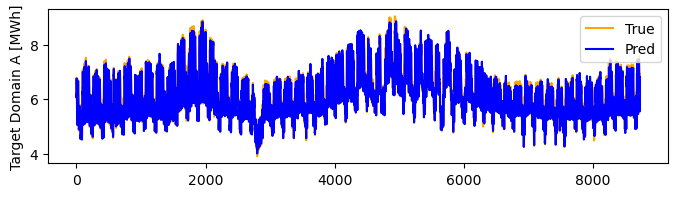

In [24]:
plt.figure(figsize=(8,2))
plt.ylabel('Target Domain A [MWh]', size=10)
plt.plot(real, color='orange',label='True')
plt.plot(pred, color='blue',label='Pred')
plt.rc('font',size=10)
plt.legend()
plt.show()